In [1]:
from continuous_simulations import spread_continuous_rumour
from discrete_simulations import spread_discrete_rumour
from networkx.classes.graph import Graph
import networkx as nx
import numpy as np
import matplotlib.pylab as plt
import matplotlib.ticker as ticker
from display_simulations import display_simulation
from math import sqrt

from matplotlib import rc
rc('animation', html='jshtml')
rc('text', usetex='True')
%matplotlib inline

## Continuous Simulations

In [2]:
c = 1.5
c_0 = 1/2 + 1/np.exp(1)
C = (10*c + 20)/c_0

In [3]:
DEFAULT_MAX_NODES = 300
x = np.linspace(5, DEFAULT_MAX_NODES, 2*DEFAULT_MAX_NODES)

In [27]:
CHECK_STEP = 40
def spreading_scaling_simulation(graph_generator, min_nodes = 10, max_nodes = DEFAULT_MAX_NODES, step = 10, runs_per_size = 10, rumour_spreader=spread_continuous_rumour):
    results = []
    means = []
    top_percentiles = []
    bottom_percentiles = []
    for n in range(min_nodes, max_nodes+1, step):
        spreading_times = [rumour_spreader(graph_generator, n) for i in range(runs_per_size)]
        # results.append((n, np.median(spreading_times)))
        spreading_time_tuples = [(n, spreading_time) for spreading_time in spreading_times]
        results.extend(spreading_time_tuples)
        means.append((n, np.mean(spreading_times)))
        top_percentiles.append((n, np.percentile(spreading_times, 99)))
        bottom_percentiles.append((n, np.percentile(spreading_times, 1)))
        if (n - min_nodes) % CHECK_STEP == 0:
            print("COMPLETED " + str(100 * float(n) / float(max_nodes))+ "%", end='\r', flush=True)
    return results, means, top_percentiles, bottom_percentiles

### Ring Graph

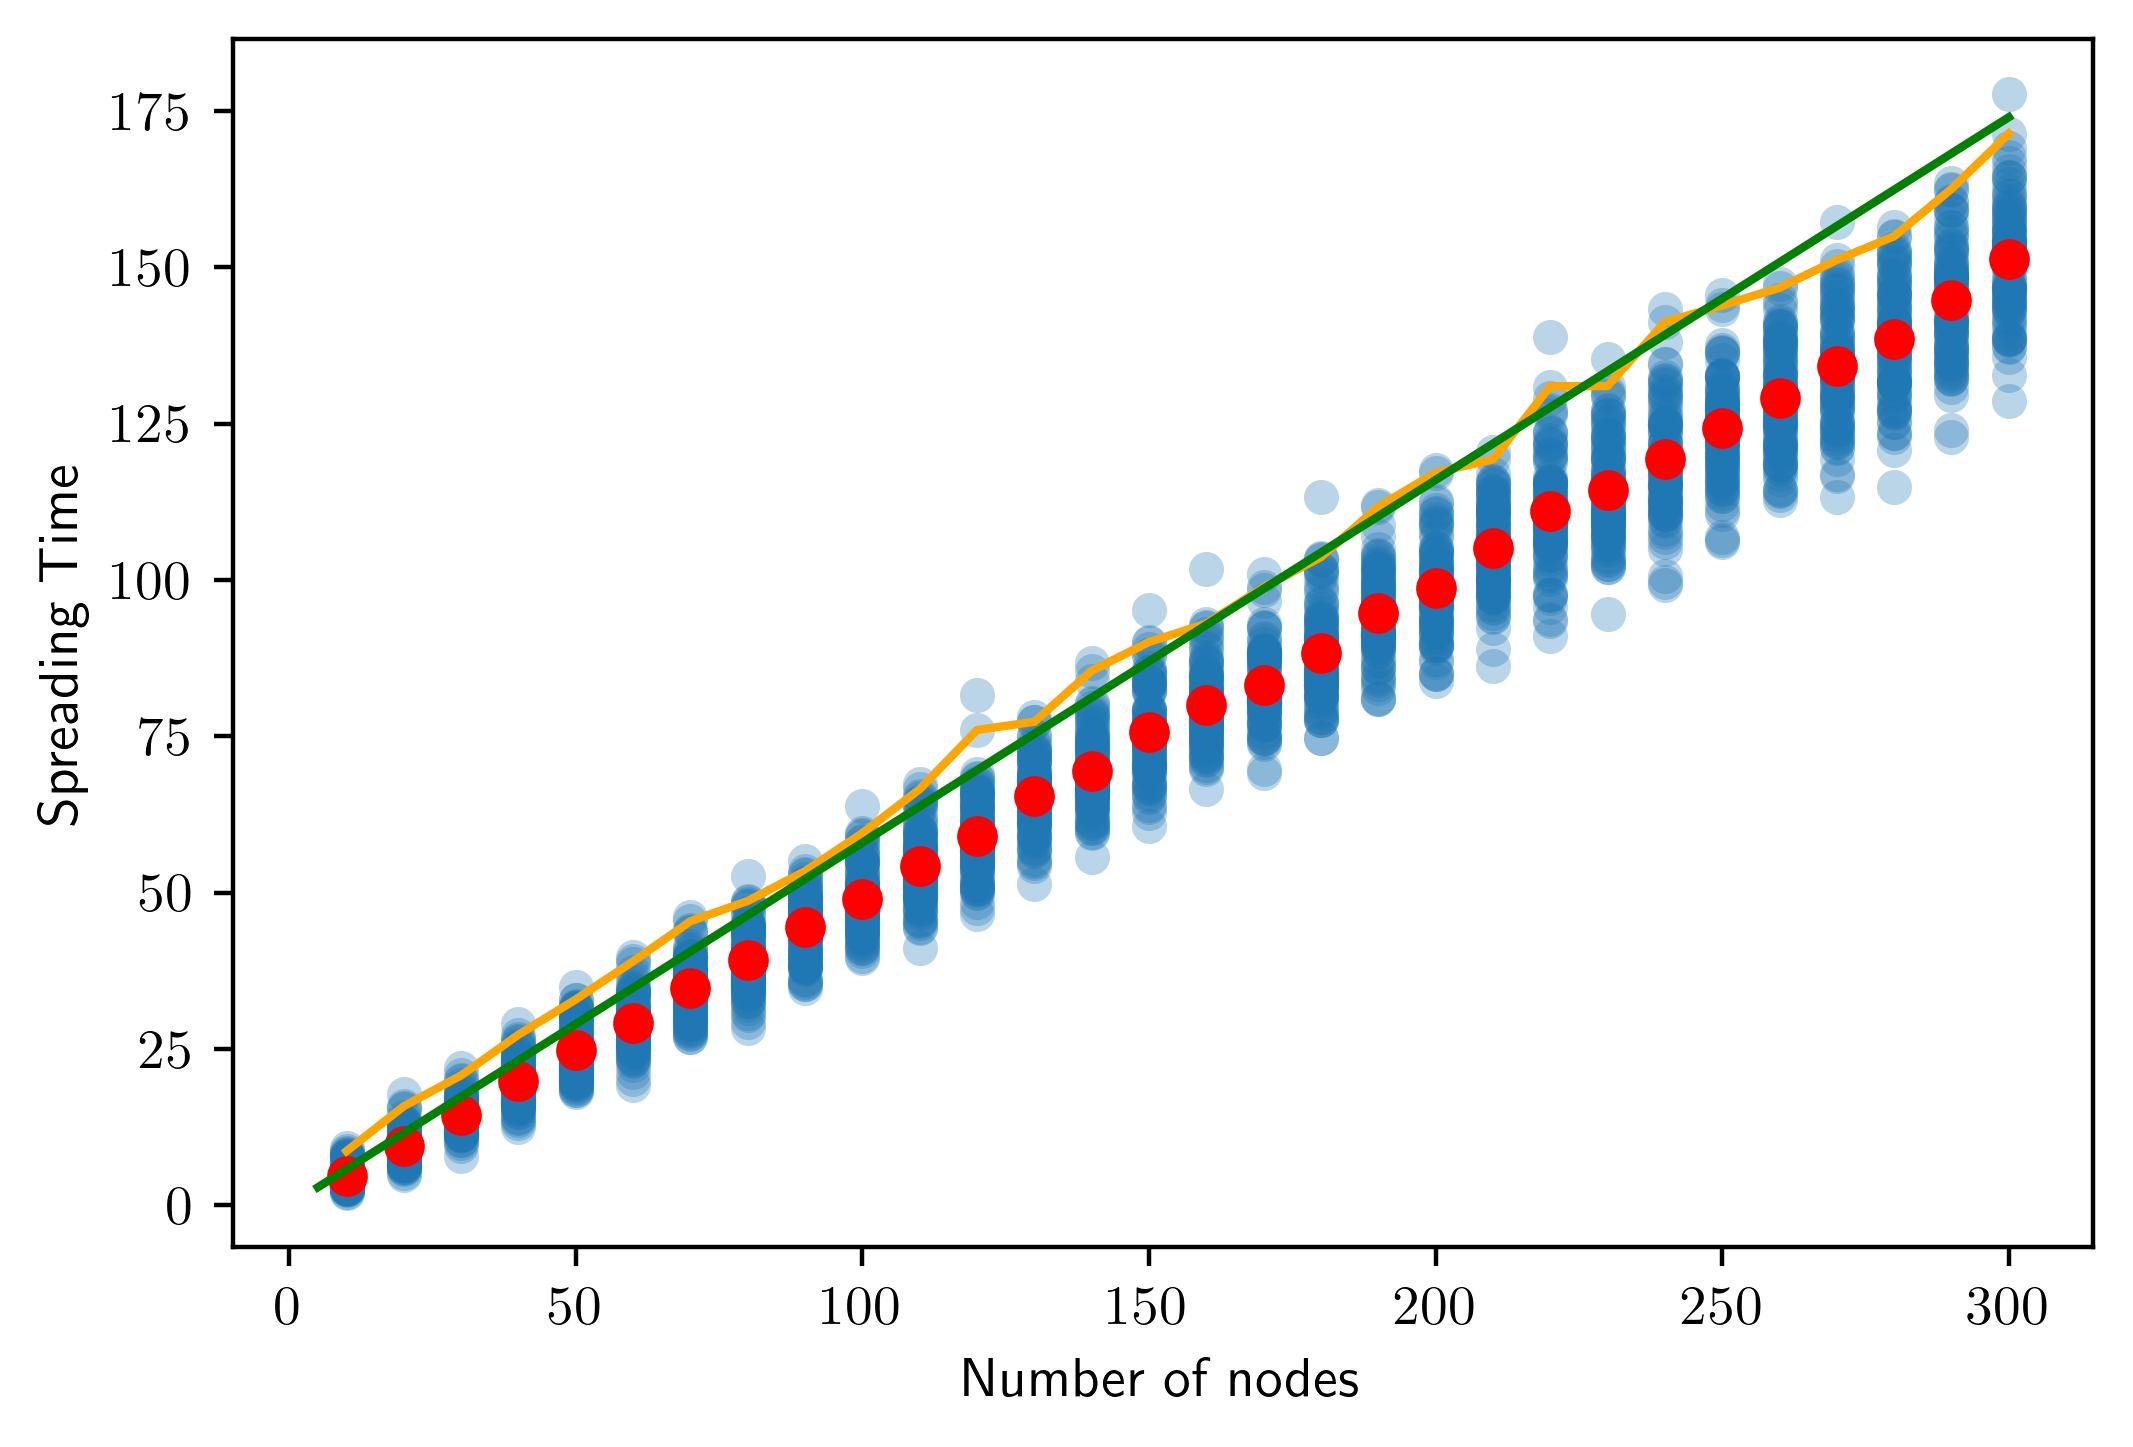

In [7]:
def ring_generator(number_of_nodes, timestep, informed_nodes) -> Graph:
    return nx.cycle_graph(number_of_nodes)

results, means, top_percentiles, bottom_percentiles = spreading_scaling_simulation(
    ring_generator, 
    runs_per_size=100, 
    max_nodes=300)

plt.figure(dpi=400)
plt.scatter(*zip(*results), alpha=0.3, linewidths=0.0, s=40)
plt.scatter(*zip(*means), c='r', s=40)
plt.plot(*zip(*top_percentiles), c='orange')
plt.xlabel("Number of nodes")
plt.ylabel("Spreading Time")
f = x * 0.58
plt.plot(x, f, 'g')
plt.show()

### Shuffled Ring Graph

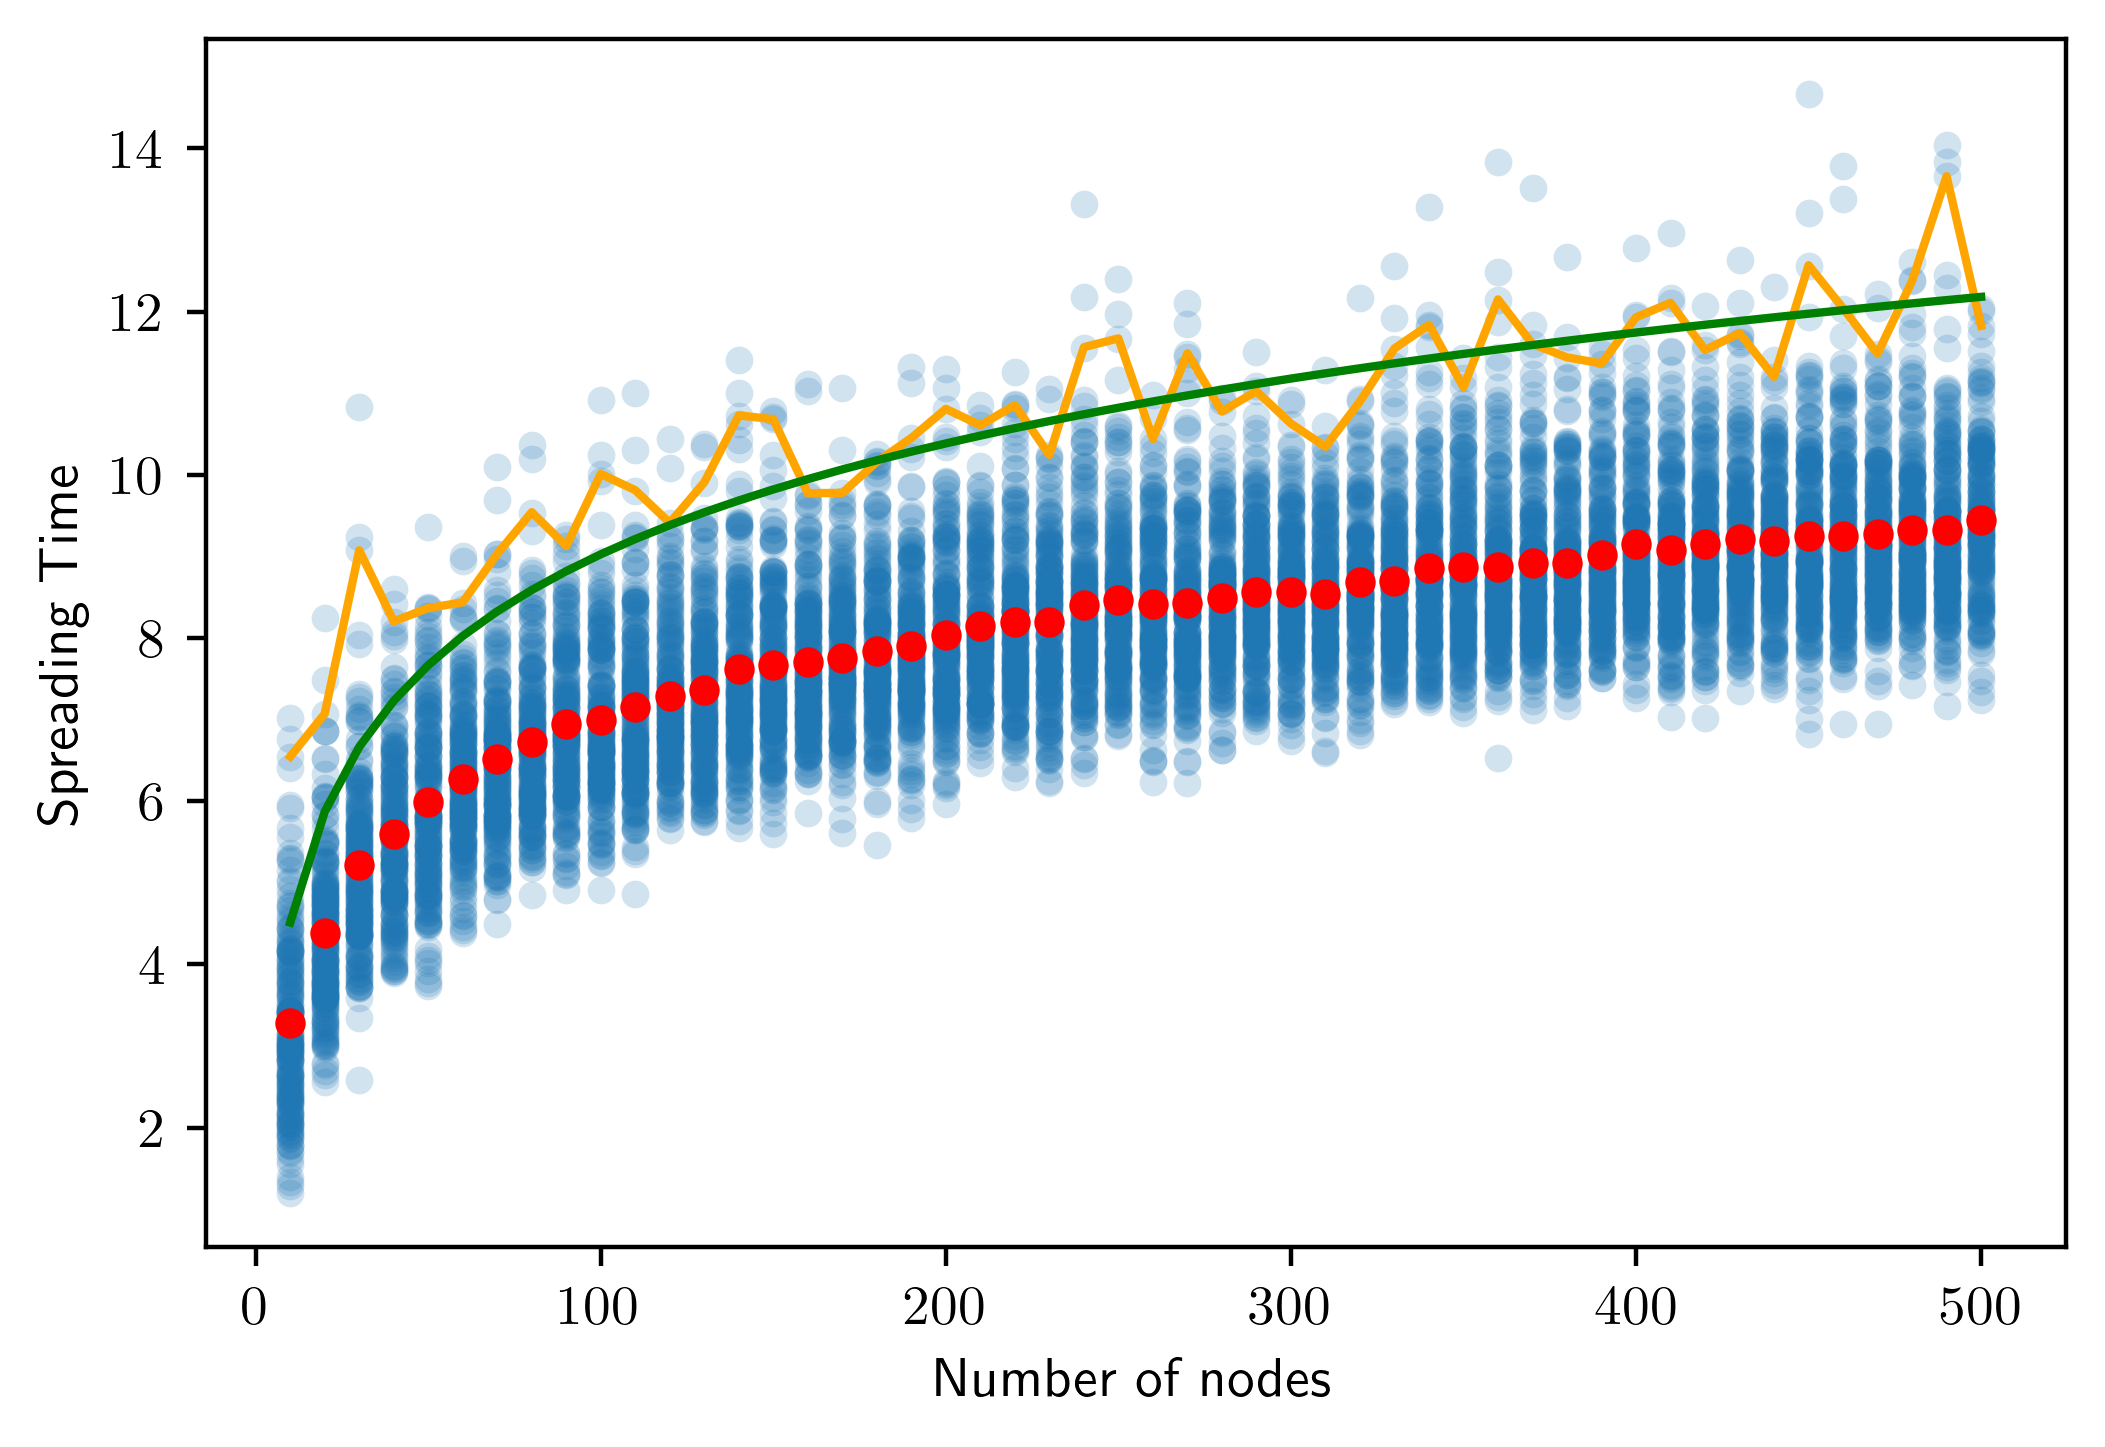

In [16]:
def shuffled_ring_generator(number_of_nodes, timestep, informed_nodes) -> Graph:
    node_permutation = np.random.permutation(number_of_nodes)
    return nx.cycle_graph(node_permutation)

#results, means, top_percentiles, bottom_percentiles = spreading_scaling_simulation(
#    shuffled_ring_generator, runs_per_size=200, max_nodes=500)

plt.figure(dpi=400)
plt.scatter(*zip(*results), alpha=0.2, linewidths=0.0, s=25)
plt.scatter(*zip(*means), c='r', s=20)
plt.plot(*zip(*top_percentiles), c='orange')
plt.xlabel("Number of nodes")
plt.ylabel("Spreading Time")
x = np.linspace(10, 500)
f = 1.96 * np.log(x)
plt.plot(x, f, 'g')
plt.show()

### Complete Graph

In [ ]:
def complete_generator(number_of_nodes, timestep, informed_nodes) -> Graph:
    return nx.complete_graph(number_of_nodes)

results, means = spreading_scaling_simulation(complete_generator)

plt.scatter(*zip(*results))
plt.scatter(*zip(*means), c='r')
# f = 2 * C * np.log(x)
# plt.plot(x, f, 'g')
plt.show()

### ER Random Graph

In [ ]:
def ER_generator(number_of_nodes, timestep, informed_nodes) -> Graph:
    p = 1/np.log(number_of_nodes)
    return nx.fast_gnp_random_graph(number_of_nodes, p)

results, means = spreading_scaling_simulation(ER_generator)

plt.scatter(*zip(*results))
plt.scatter(*zip(*means), c='r')
plt.show()

### Static Star Graph (Initial node not hub)

In [ ]:
def static_star_generator(number_of_nodes, timestep, informed_nodes) -> Graph:
    # Generates list [1,2, ..., number_of_nodes - 1, 0]
    # First node in list is hub
    nodes = [(i+1) % number_of_nodes for i in range(number_of_nodes)]

    return nx.star_graph(nodes)

results, means = spreading_scaling_simulation(static_star_generator)

plt.scatter(*zip(*results))
plt.scatter(*zip(*means), c='r')
f = C * np.log(x)
plt.plot(x, f, 'r')
plt.show()

### Adversarial Star Graph 

In [ ]:
def adversarial_star_generator(number_of_nodes, timestep, informed_nodes) -> Graph:
    uninformed_nodes = [v for v in range(number_of_nodes) if not (v in informed_nodes)]
    if len(informed_nodes) <= number_of_nodes / 2:
        node_set = uninformed_nodes + list(informed_nodes)
    else:
        node_set = list(informed_nodes) + uninformed_nodes
    return nx.star_graph(node_set)

results, means = spreading_scaling_simulation(adversarial_star_generator)

plt.scatter(*zip(*results))
plt.scatter(*zip(*means), c='r')
f = C * np.log(x)
plt.plot(x, f, 'r')
plt.show()

In [ ]:
events = spread_continuous_rumour(adversarial_star_generator, 10, enable_event_log=True)
# display_simulation(events)

### Shuffled Star Graph

In [ ]:
def shuffled_star_generator(number_of_nodes, timestep, informed_nodes) -> Graph:
    node_permutation = np.random.permutation(number_of_nodes)
    return nx.star_graph(node_permutation)

results, means = spreading_scaling_simulation(shuffled_star_generator)

plt.scatter(*zip(*results))
plt.scatter(*zip(*means), c='r')
plt.show()

### Complete Graph String

In [ ]:
SUBGRAPH_SIZE = 10
def complete_string_generator(number_of_nodes, timestep, informed_nodes):
    number_of_subgraphs = int(number_of_nodes / SUBGRAPH_SIZE)
    complete_graphs = [nx.complete_graph(SUBGRAPH_SIZE) for i in range(number_of_subgraphs)]
    g = nx.disjoint_union_all(complete_graphs)
    for i in range(number_of_subgraphs - 1):
        g.add_edge(i * SUBGRAPH_SIZE, (i+1)*SUBGRAPH_SIZE + SUBGRAPH_SIZE - 1)
    return g

results, means = spreading_scaling_simulation(complete_string_generator, step=50)

plt.scatter(*zip(*results))
plt.scatter(*zip(*means), c='r')
plt.show()

### Ring-Complete Alternating Graph

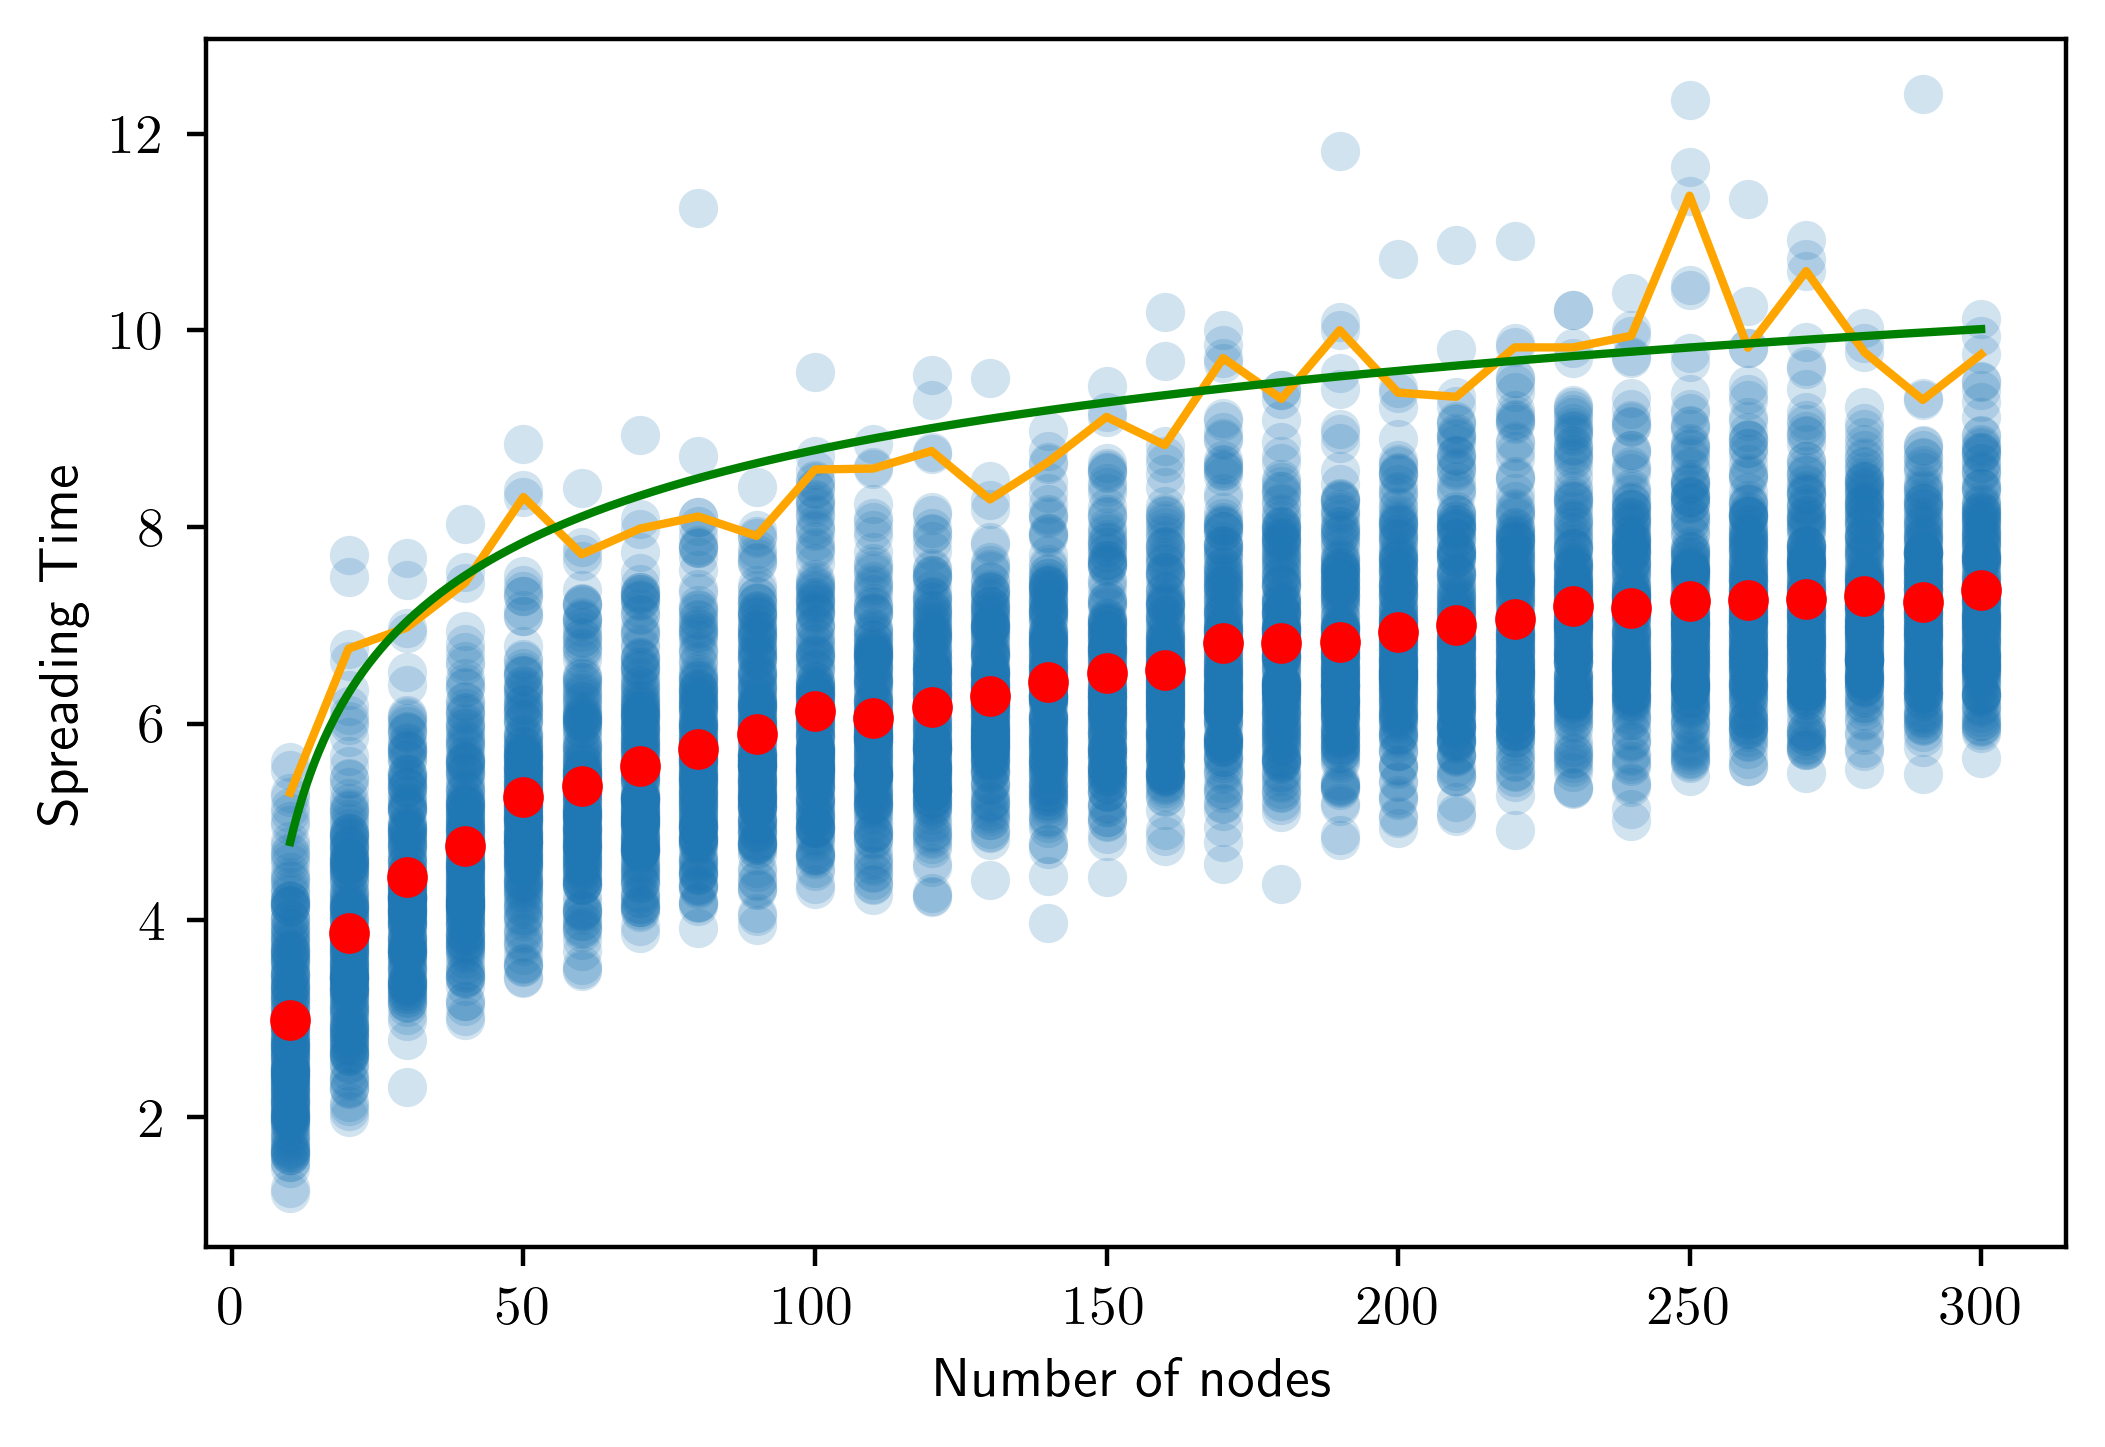

In [20]:
def alternating_generator(number_of_nodes, timestep, informed_nodes):
    if timestep % 2 == 0:
        return nx.cycle_graph(number_of_nodes)
    else:
        return nx.complete_graph(number_of_nodes)

#results, means, top_percentiles, bottom_percentiles = spreading_scaling_simulation(
#    alternating_generator, runs_per_size=200, max_nodes=300)


plt.figure(dpi=400)
plt.scatter(*zip(*results), alpha=0.2, linewidths=0.0, s=50)
plt.scatter(*zip(*means), c='r', s=40)
plt.plot(*zip(*top_percentiles), c='orange')
plt.xlabel("Number of nodes")
plt.ylabel("Spreading Time")
x = np.linspace(10, 300, 2*300)
f = 5.75*np.log(np.log(x))
plt.plot(x, f, 'g')
plt.show()

## Spread Step Functions

### Ring

In [ ]:
def ring_generator(number_of_nodes, timestep, informed_nodes) -> Graph:
    return nx.cycle_graph(number_of_nodes)

events = spread_continuous_rumour(ring_generator, 500, enable_event_log=True)

x = [event['time'] for event in events]
y = [len(event['informed_nodes']) for event in events]
plt.figure(dpi = 400)
plt.step(x, y, where='post')
plt.xlabel("Time")
plt.ylabel("Number of informed nodes")
plt.show()

### Shuffled Ring

In [ ]:
def shuffled_ring_generator(number_of_nodes, timestep, informed_nodes) -> Graph:
    node_permutation = np.random.permutation(number_of_nodes)
    return nx.cycle_graph(node_permutation)

events = spread_continuous_rumour(shuffled_ring_generator, 500, enable_event_log=True)

x = [event['time'] for event in events]
y = [len(event['informed_nodes']) for event in events]
plt.figure(dpi = 400)
plt.step(x, y, where='post')
plt.xlabel("Time")
plt.ylabel("Number of informed nodes")
plt.show()

## Flooding Simulations

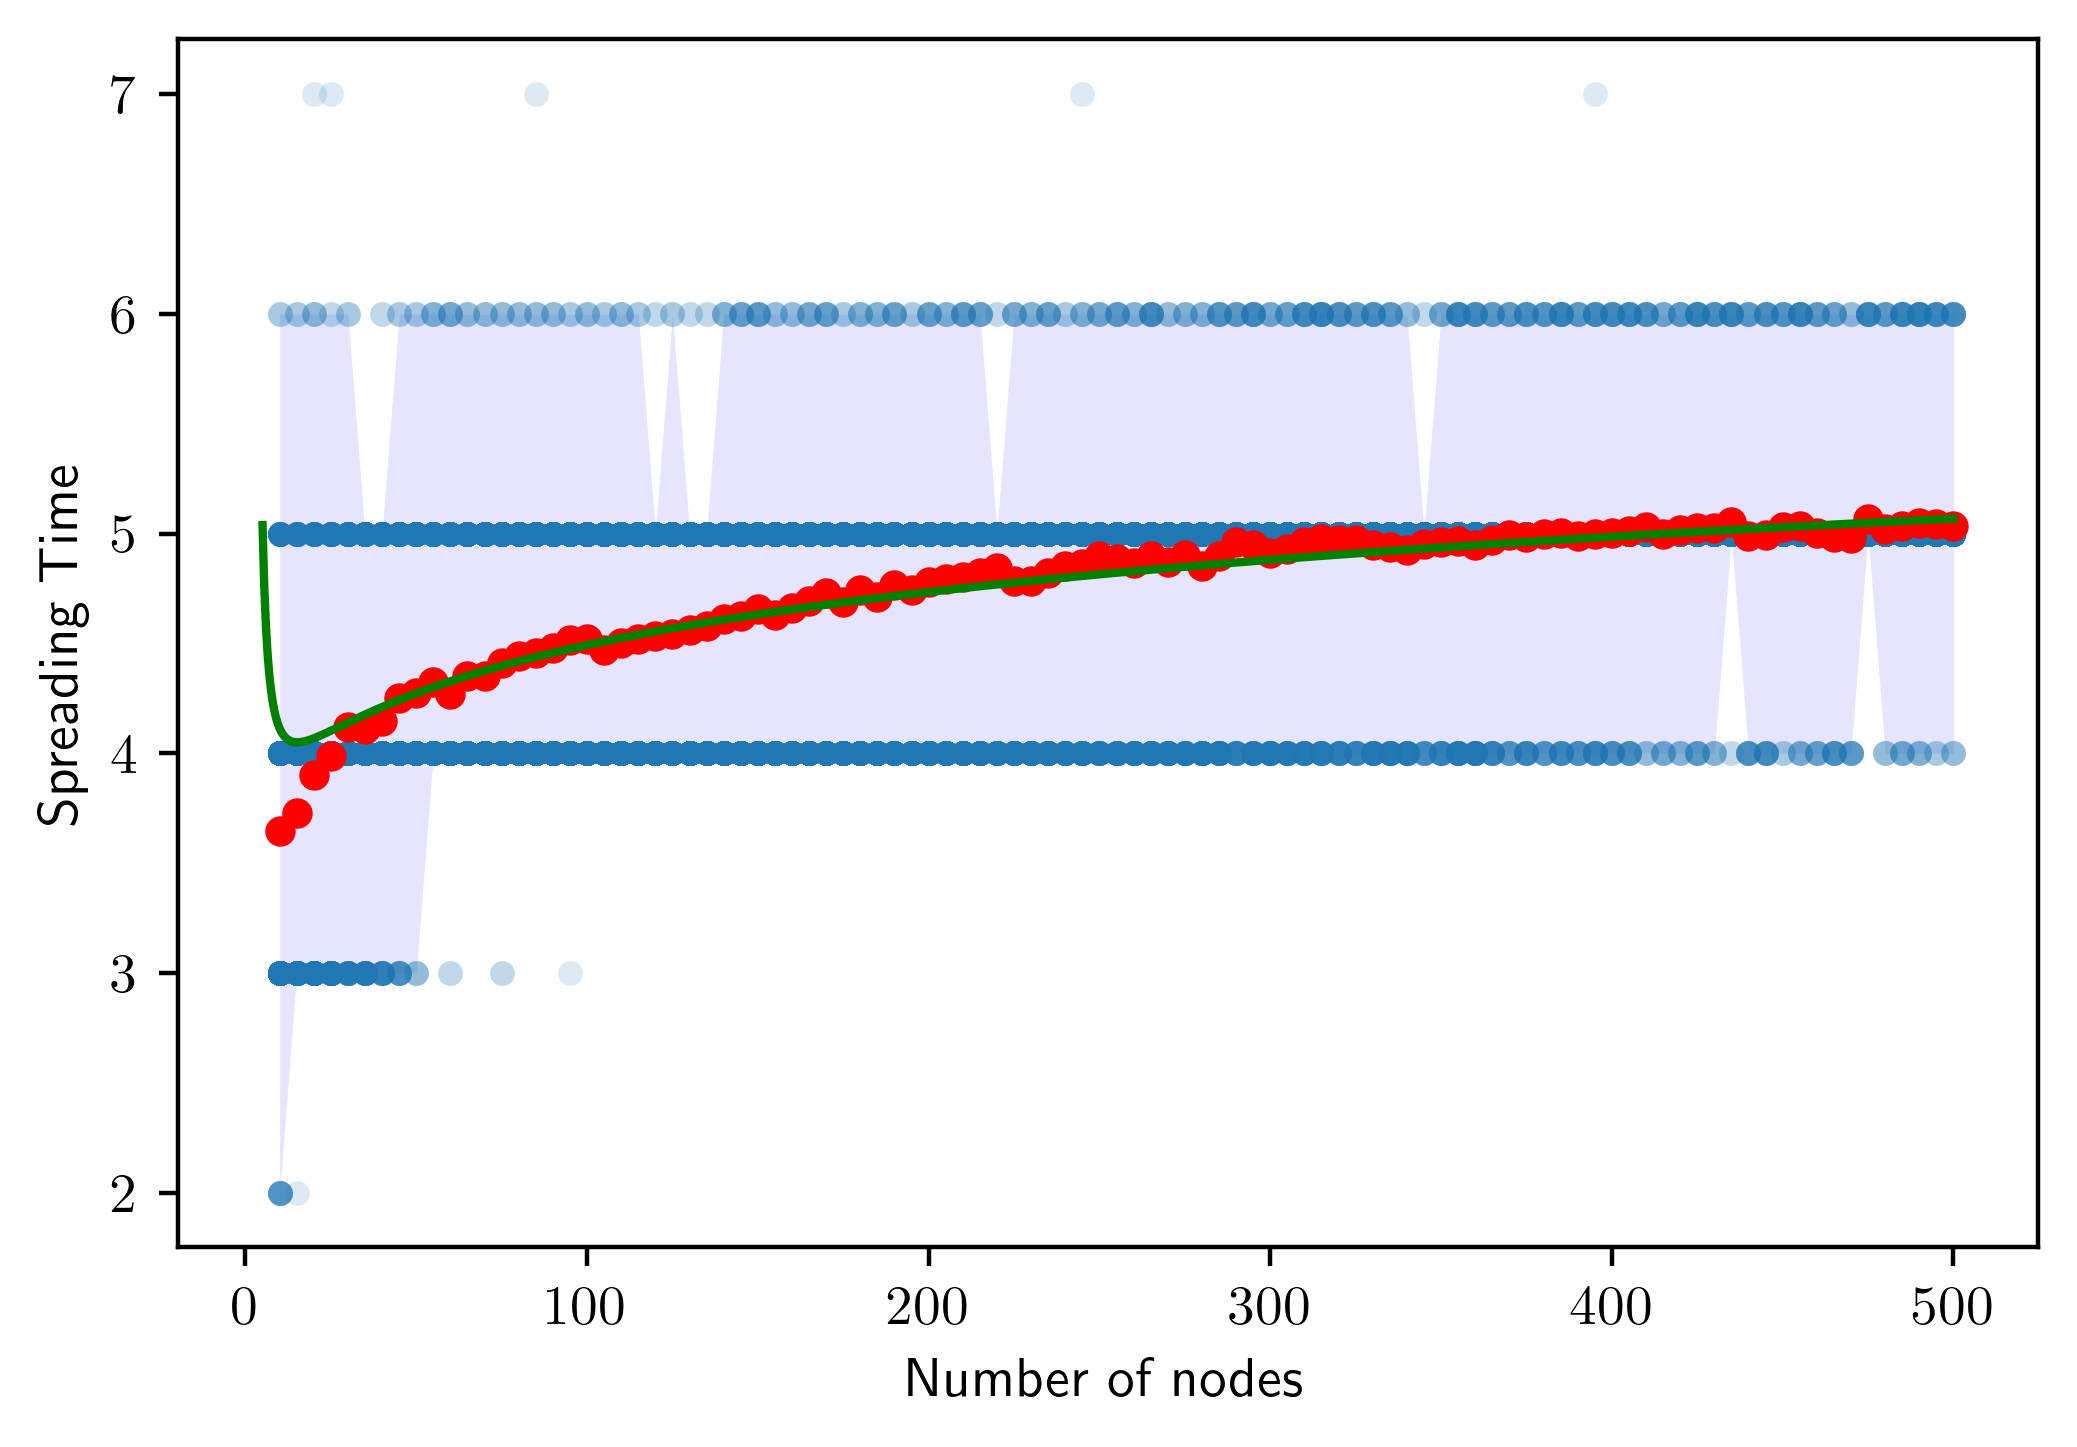

In [30]:
def generate_p(n):
    return (np.log(n)) / n

def gnp_generator(number_of_nodes, timestep, informed_nodes) -> Graph: 
    p = generate_p(number_of_nodes)
    return nx.gnp_random_graph(number_of_nodes, p)

# results, means, top_percentiles, bottom_percentiles = spreading_scaling_simulation(gnp_generator, 
#                                              rumour_spreader = spread_discrete_rumour, 
#                                              runs_per_size=200,
#                                              step=5,
#                                              max_nodes = 500)


plt.figure(dpi=400)
plt.fill_between(*zip(*top_percentiles), 
                 list(zip(*bottom_percentiles))[1], 
                 color='b', alpha=0.1, linewidth=0)
plt.scatter(*zip(*results), alpha=0.15, linewidths=0.0, s=20)
plt.scatter(*zip(*means), c='r', s=20)
plt.xlabel("Number of nodes")
plt.ylabel("Spreading Time")
x = np.linspace(5, 500, 2*500)
f =  1.49 * np.log(x) / np.log(x * generate_p(x))
plt.plot(x, f, 'g')
plt.show()

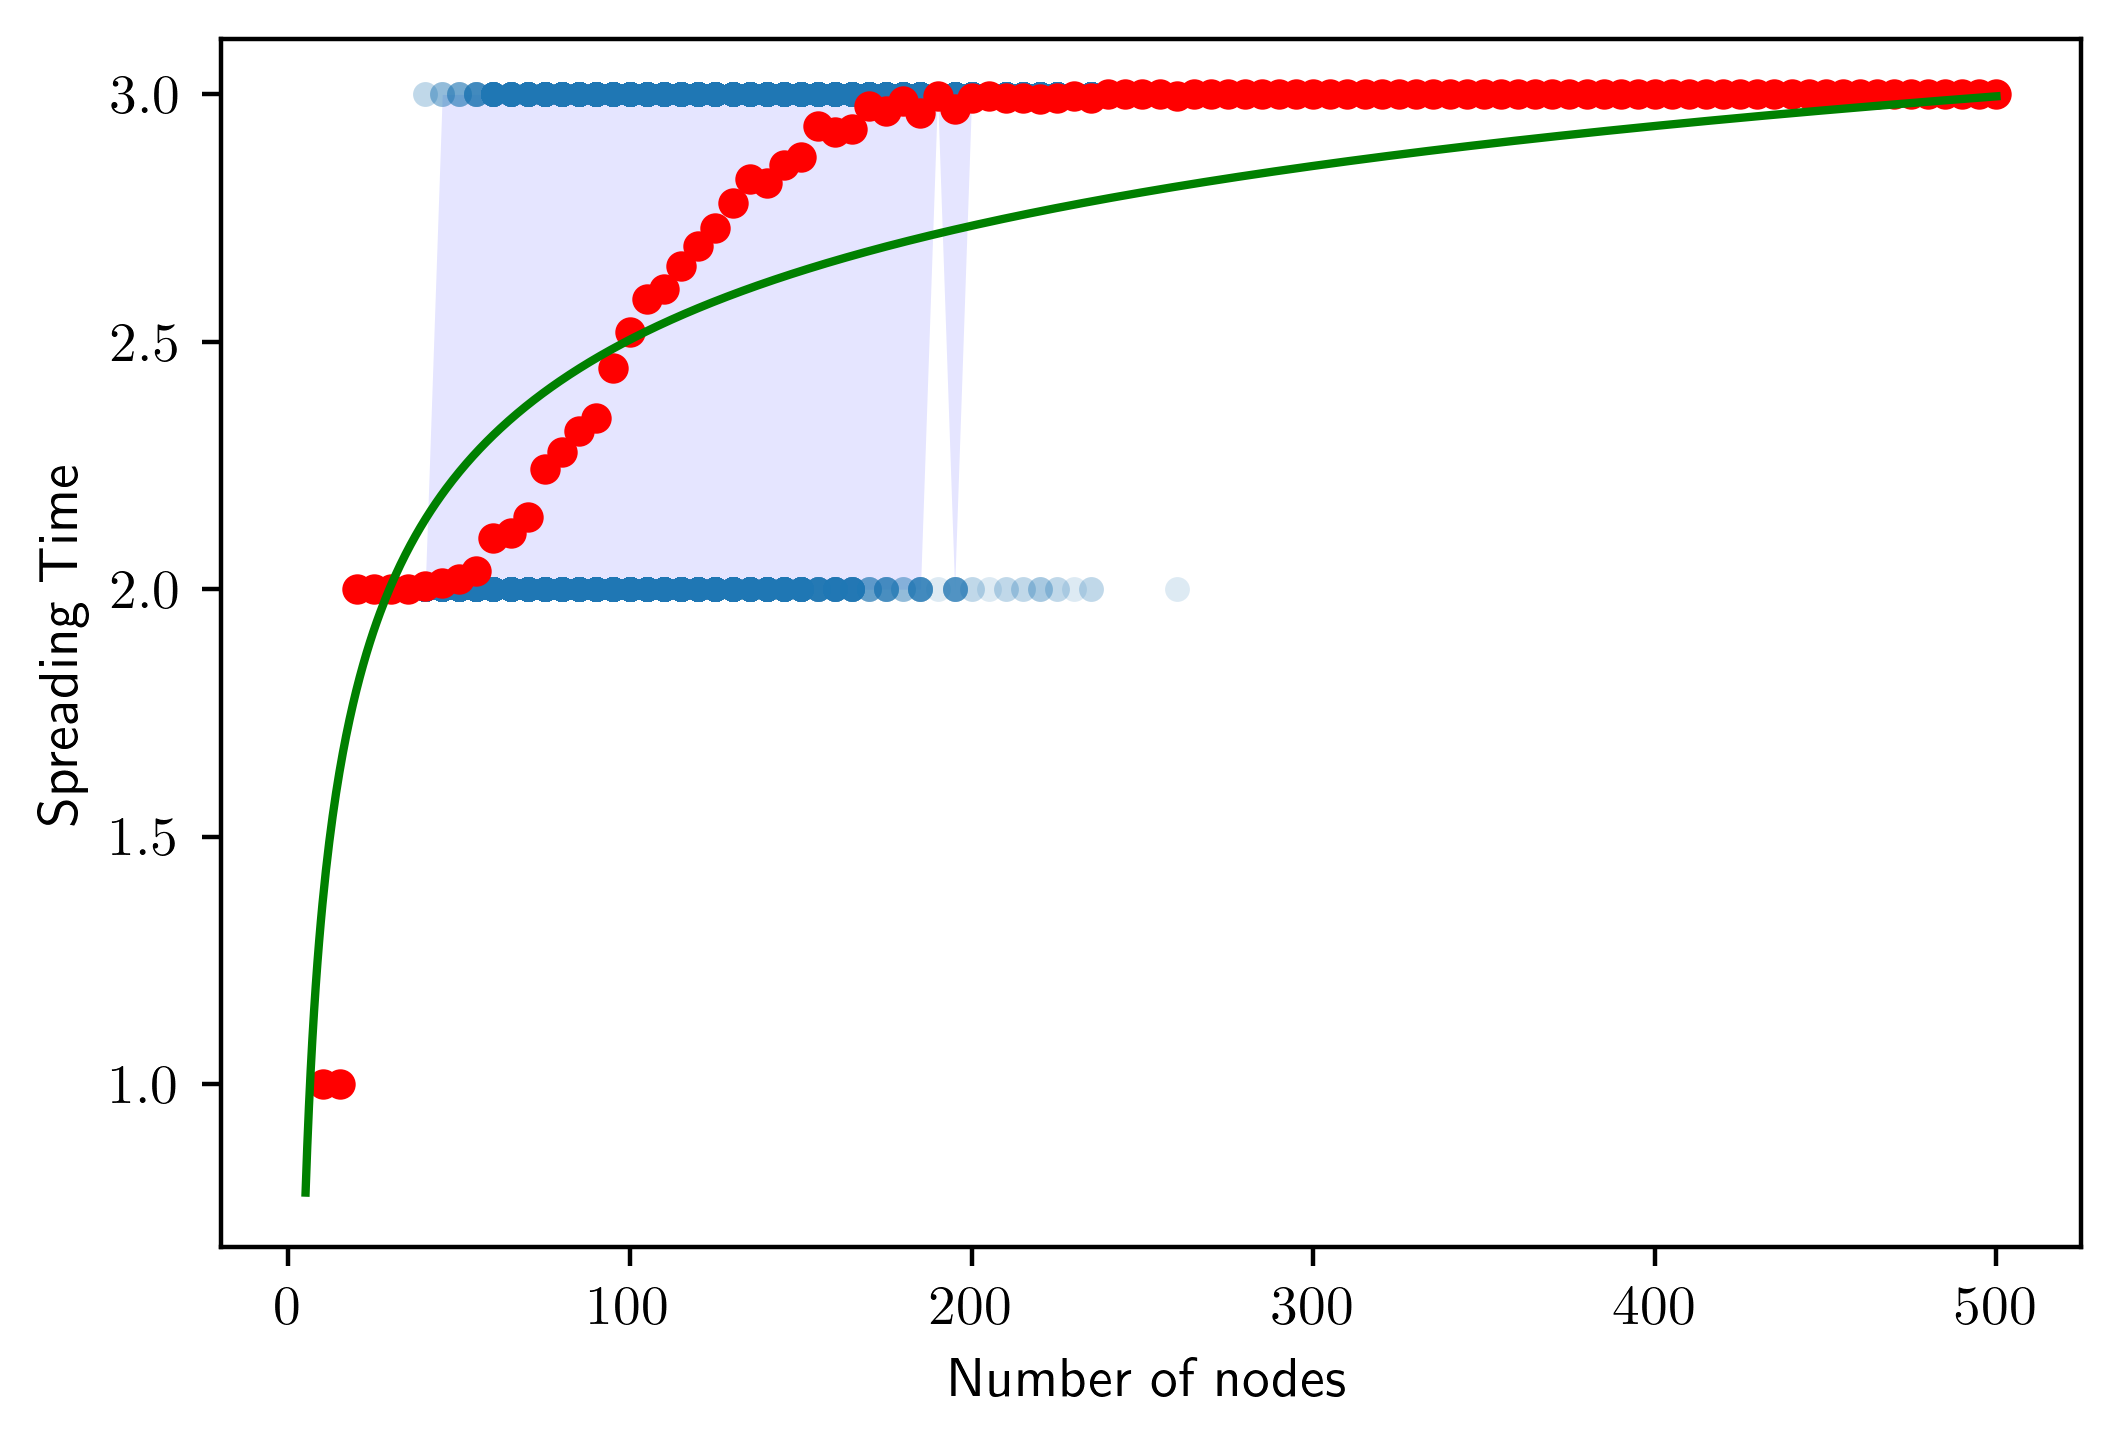

In [39]:
def generate_p(n):
    return (n ** (1/np.log(np.log(n))))  / (n)

def gnp_generator(number_of_nodes, timestep, informed_nodes) -> Graph: 
    p = generate_p(number_of_nodes)
    return nx.gnp_random_graph(number_of_nodes, p)

# results, means, top_percentiles, bottom_percentiles = spreading_scaling_simulation(
#     gnp_generator, 
#     rumour_spreader = spread_discrete_rumour, 
#     runs_per_size=300,
#     step=5,
#     max_nodes = 500)


plt.figure(dpi=400)
plt.fill_between(*zip(*top_percentiles), 
                 list(zip(*bottom_percentiles))[1], 
                 color='b', alpha=0.1, linewidth=0)
plt.scatter(*zip(*results), alpha=0.15, linewidths=0.0, s=20)
plt.scatter(*zip(*means), c='r', s=20)
plt.xlabel("Number of nodes")
plt.ylabel("Spreading Time")
x = np.linspace(5, 500, 2*500)
f =  1.64 * np.log(x) / np.log(x * generate_p(x))
plt.plot(x, f, 'g')
plt.show()

In [ ]:
def generate_p(n):
    return np.log(n) / sqrt(n)

def gnp_generator(number_of_nodes, timestep, informed_nodes) -> Graph: 
    p = generate_p(number_of_nodes)
    return nx.gnp_random_graph(number_of_nodes, p)

results, means = spreading_scaling_simulation(
                    gnp_generator, 
                    rumour_spreader = spread_discrete_rumour, 
                    runs_per_size=1,
                    step=1000,
                    max_nodes = 10000)

plt.figure(dpi=400)
plt.scatter(*zip(*results), alpha=0.15, linewidths=0.0, s=20)
plt.scatter(*zip(*means), c='r', s=20)
plt.xlabel("Number of nodes")
plt.ylabel("Spreading Time")
plt.show()